In [1]:
from __future__ import division
from __future__ import print_function

import sys
import os
import argparse
import time
import random
from glob import glob

import align.detect_face
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import misc
from scipy.interpolate import Rbf
from skimage import io, transform
from six.moves import xrange

import tensorflow as tf
import tensorflow.contrib.slim as slim

import facenet
import helper

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion() # interactive mode

In [2]:
landmarks_frame = pd.read_csv('./face_landmarks_generate.csv')
file_list = landmarks_frame.image_name.values.tolist()

In [3]:
batch_size = 8

In [4]:
avgP_container = np.load('f_avgP_list.npz')
emb_container = np.load('f_emb_list.npz')

train_set = []
test_set = []

for key in sorted(emb_container, key=lambda x: int(x.strip('arr_'))) :
    batch = avgP_container[key], emb_container[key]
    if len(batch[0]) is batch_size :
        train_set.append(batch)
    else :
        test_set.append(batch)

test_set_index = len(train_set)

In [5]:
t_dataset = helper.Dataset('nf',file_list, 160)
print(t_dataset.shape)

(7867, 160, 160, 3)


In [6]:
print(len(train_set))

983


In [7]:
def F_layer(encoded, f_num = 128) : 
    with tf.variable_scope('F') :
        fc = slim.fully_connected(encoded, f_num, activation_fn=tf.nn.relu, scope='fc')
    return fc

In [8]:
def MLP(net, landmark_num = 68, reuse=None, scope='MLP'):
    """Builds the MLP for landmark"""
    with tf.variable_scope(scope, 'MLP') :
        net = slim.fully_connected(net, 256, activation_fn=None, scope='fc0')
        net = slim.fully_connected(net, 128, activation_fn=None, scope='fc1')
        net = slim.fully_connected(net, landmark_num, activation_fn=tf.nn.relu, scope='fc2')
    return net

In [9]:
def landmark_decode(net, landmark_num = 68):
    with tf.variable_scope('landmark') :
        decoded_x = MLP(net, scope= 'decoded_x')
        decoded_y = MLP(net, scope= 'decoded_y')
    return decoded_x, decoded_y

In [10]:
def CNN(F, size) :
    with tf.variable_scope('CNN') :
        # 12 x 12 x 256
        f_size = int(size / 8)
        features = slim.fully_connected(F, f_size * f_size * 256, activation_fn=None, scope="features")
        features = tf.reshape(features, [-1, f_size, f_size, 256])
        # print(features.shape)
        
        # 24 x 24 x 128
        upsample_0 = slim.conv2d_transpose(features, 128, 5, stride=2, scope="upsample_0")
        # print(upsample_0.shape)
        
        # 48 x 48 x 64
        upsample_1 = slim.conv2d_transpose(upsample_0, 64, 5, stride=2, scope="upsample_1")
        # print(upsample_1.shape)
        
        # 96 x 96 x 32
        upsample_2 = slim.conv2d_transpose(upsample_1, 32, 5, stride=2, scope="upsample_2")
        # print(upsample_2.shape)
        
        # 96 x 96 x 3
        one_by_one_conv = slim.conv2d(upsample_2, 3, 1, stride=1, activation_fn=None, scope="one_by_one_conv")
        # print(one_by_one_conv.shape)
    return one_by_one_conv

In [11]:
def texture_decode(net, size) :
    with tf.variable_scope('texture') :
        cnn = CNN(net, size)
    return cnn

In [12]:
def get_grids(size):
    return np.mgrid[0:size-1:(size * 1j), 0:size-1:(size * 1j)]

In [13]:
def get_zero_displacement(size):
    mid = size/2
    end = size-1
    
    zero_displacement = [[0,0], 
                         [0, mid], 
                         [0, end], 
                         [mid, 0], 
                         [end,0], 
                         [end, mid], 
                         [end, end], 
                         [mid, end]]
    return zero_displacement

In [14]:
def rbf_tf(pred_x, pred_y, correct_points, grids, grid_shape):
    def _euclidean_norm_tf(x1, x2):    
        return tf.sqrt(tf.reduce_sum(((x1 - x2)**2), 1))

    def _h_linear_tf(r):
        return r

    def _call_norm_tf(x1, x2):
        x1 = tf.expand_dims(x1, 3) 
        x2 = tf.expand_dims(x2, 2) 
        return norm(x1, x2)    

    # set parameters
    norm = _euclidean_norm_tf
    basis_function = _h_linear_tf
    epsilon = tf.constant(2.)
    smooth = tf.constant(1.)

    xi = tf.concat([tf.expand_dims(pred_x, 1), tf.expand_dims(pred_y, 1)], 1) # (None, 2, 76)
    N = xi.shape[-1].value # same as landmarks_num => 76
    di = tf.expand_dims(correct_points, 2) # (None, 76, 1)
    
    r = _call_norm_tf(xi, xi) # (None, 76, 76)
    
    batch_shape = tf.shape(pred_x)[0:1]
    A = tf.subtract(basis_function(r), tf.multiply(smooth, tf.eye(N, batch_shape= batch_shape)))

    nodes = tf.matrix_solve (A, di)
    r2 = _call_norm_tf(grids, xi)
    return tf.reshape(tf.matmul(r2, nodes), [-1, grid_shape[0], grid_shape[1]])

In [15]:
def warp_tf(data, pred_x, pred_y, correct_x, correct_y, grids, grid_shape, zero_displacement) :
    
    pred_x_zd = tf.concat([pred_x, zero_displacement[0]], axis=1)
    pred_y_zd = tf.concat([pred_y, zero_displacement[0]], axis=1)
    correct_x_zd = tf.concat([correct_x, zero_displacement[1]], axis=1)
    correct_y_zd = tf.concat([correct_y, zero_displacement[1]], axis=1)
    
    rbf_x = rbf_tf(pred_x_zd, pred_y_zd, correct_x_zd, grids, grid_shape)
    rbf_y = rbf_tf(pred_x_zd, pred_y_zd, correct_y_zd, grids, grid_shape)
    warp = tf.concat([tf.expand_dims(rbf_x, 3), tf.expand_dims(rbf_y, 3)], axis=3)
    resample = tf.contrib.resampler.resampler(data=data, warp=warp)
    return resample

In [16]:
epochs = 200

avgP_num = 1792
emb_num = 128
f_num = 1024

l_num = 68
zd_l_num = 76
t_size = 160
t_channel = 3

grid_y, grid_x = get_grids(t_size)
grid_shape = grid_x.shape
xa = np.asarray([a.flatten() for a in [grid_x, grid_y]], dtype=np.float_) # (2, 25600)
xa = np.asarray([xa for _ in range(0, batch_size)], dtype=np.float_) # (batch_size, 2, 25600)

zd = get_zero_displacement(t_size)
zd = np.asarray([zd for _ in range(0, batch_size)], dtype=np.float_)

In [17]:
g = tf.Graph()
with g.as_default():
    # placeholder
    avgP_inputs = tf.placeholder(tf.float32, (None, avgP_num), name='avgP_inputs')
    
    l_x_labels = tf.placeholder(tf.float32, (None, l_num), name='l_x_labels')
    l_y_labels = tf.placeholder(tf.float32, (None, l_num), name='l_y_labels')
    t_labels = tf.placeholder(tf.float32, (None, t_size, t_size, t_channel), name='t_labels')
    w_labels = tf.placeholder(tf.float32, shape=(None, emb_num), name= 'w_labels')
    
    grids = tf.constant(xa, dtype=tf.float32, name= 'grids')
    zero_displacement = (tf.constant(zd[:, :, 0], dtype=tf.float32, name= 'zd_x'), 
                         tf.constant(zd[:, :, 1], dtype=tf.float32, name= 'zd_y'))
    
    # model
    F = F_layer(avgP_inputs, f_num= f_num)
    
    (l_x_preds, l_y_preds) = landmark_decode(F, landmark_num= l_num)
    
    l_x_loss = tf.losses.mean_squared_error(l_x_labels, l_x_preds, reduction="weighted_mean")
    l_y_loss = tf.losses.mean_squared_error(l_y_labels, l_y_preds, reduction="weighted_mean")
    
    l_loss = tf.add(l_x_loss, l_y_loss)
    
    t_preds = texture_decode(F, t_size)
    t_loss = tf.losses.absolute_difference(t_labels, t_preds)
    
    warp = warp_tf(t_preds, l_x_preds, l_y_preds, l_x_labels, l_y_labels, grids, grid_shape, zero_displacement)
    cast_warp = tf.cast(warp, tf.uint8)
    
    w_loss = tf.losses.absolute_difference(t_labels, warp)
    
    total_cost = l_loss + t_loss + w_loss
    
    opt = tf.train.AdamOptimizer(0.001).minimize(total_cost)

In [18]:
with g.as_default():
    time_load_data = time.time()
    
    #facenet
    start_load_facenet = time.time()
    print("--- %s start load facenet ---" % (start_load_facenet))
    facenet.load_model('./20171012', input_map={"input:0": warp})
    print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

    f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    w_preds = tf.get_default_graph().get_tensor_by_name("embeddings:0")    
    w_loss = tf.losses.cosine_distance(tf.nn.l2_normalize(w_labels, 1), 
                                       tf.nn.l2_normalize(w_preds, 1), dim=1)
    
    total_cost = l_loss + t_loss + w_loss
    
    opt = tf.train.AdamOptimizer(0.001).minimize(total_cost)

--- 1507905957.9133556 start load facenet ---
Model filename: ./20171012
--- 4.14647912979126 facenet loaded ---


KeyboardInterrupt: 

In [18]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)

In [19]:
def show_test(l_x, l_y, t, index):
    index = len(train_set) * batch_size + index
    img_name = landmarks_frame.ix[index, 0]
    landmarks = landmarks_frame.ix[index, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2) # (68, 2)
    
    plt.figure()
    show_landmarks(io.imread(os.path.join('', img_name)), landmarks)
    plt.show()
    
    t_img = scipy.misc.toimage(t)
    plt.imshow(t_img)
    plt.scatter(l_x, l_y, s=10, marker='.', c='b')
    plt.pause(0.001)
    plt.show()

#     plt.imshow(np.squeeze(w, axis=0))
#     plt.show()

In [20]:
print(test_set[0][0].shape)

(3, 1, 1, 1792)


Iter: 1/983 Training loss: X = 886.0668, Y = 937.9265, T = 0.2788, W = 0.2788
Iter: 11/983 Training loss: X = 963.0005, Y = 986.8723, T = 0.2342, W = 0.2366
Iter: 21/983 Training loss: X = 841.5565, Y = 934.3865, T = 0.2623, W = 0.2721
Iter: 31/983 Training loss: X = 929.8198, Y = 929.9586, T = 0.2551, W = 0.2572
Iter: 41/983 Training loss: X = 921.1740, Y = 966.8798, T = 0.1709, W = 0.1756
Iter: 51/983 Training loss: X = 901.9697, Y = 1016.2380, T = 0.2557, W = 0.2632
Iter: 61/983 Training loss: X = 927.0244, Y = 1108.1221, T = 0.2236, W = 0.2339
Iter: 71/983 Training loss: X = 861.6548, Y = 979.6013, T = 0.2489, W = 0.2577
Iter: 81/983 Training loss: X = 963.5535, Y = 945.2930, T = 0.2211, W = 0.2250
Iter: 91/983 Training loss: X = 870.0294, Y = 867.2633, T = 0.2856, W = 0.2785
Iter: 101/983 Training loss: X = 840.7332, Y = 1016.8267, T = 0.2273, W = 0.2307
Iter: 111/983 Training loss: X = 895.4495, Y = 1108.9855, T = 0.1658, W = 0.1685
Iter: 121/983 Training loss: X = 863.3697, Y = 

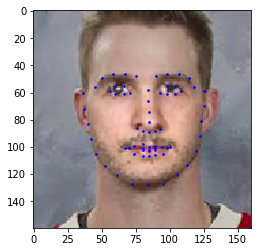

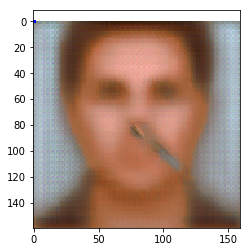

Epoch: 1/200 Time: 428.66139912605286
Model saved in file: ./tmp/model_1.ckpt Time: 440.4852297306061
Iter: 1/983 Training loss: X = 888.7686, Y = 940.8143, T = 0.2101, W = 0.2537
Iter: 11/983 Training loss: X = 963.0005, Y = 986.8723, T = 0.2056, W = 0.2345
Iter: 21/983 Training loss: X = 841.5565, Y = 934.3865, T = 0.2489, W = 0.2693
Iter: 31/983 Training loss: X = 929.8198, Y = 929.9586, T = 0.2266, W = 0.2549
Iter: 41/983 Training loss: X = 921.1740, Y = 966.8798, T = 0.1729, W = 0.1747
Iter: 51/983 Training loss: X = 901.9697, Y = 1016.2380, T = 0.2419, W = 0.2615
Iter: 61/983 Training loss: X = 927.0244, Y = 1108.1221, T = 0.2129, W = 0.2301
Iter: 71/983 Training loss: X = 861.6548, Y = 979.6013, T = 0.2333, W = 0.2582
Iter: 81/983 Training loss: X = 963.5535, Y = 945.2930, T = 0.1994, W = 0.2229
Iter: 91/983 Training loss: X = 870.0294, Y = 867.2633, T = 0.2505, W = 0.2812
Iter: 101/983 Training loss: X = 840.7332, Y = 1016.8267, T = 0.2033, W = 0.2326
Iter: 111/983 Training los

KeyboardInterrupt: 

In [21]:
with g.as_default():
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        
        start_test = time.time()
        
        for e in range(epochs):
            for i, ((f_avgP, f_emb), t_label_batch) in enumerate(zip(train_set, t_dataset.get_batches(batch_size))):
                start = i * batch_size
                end = min(start+batch_size, len(train_set) * batch_size)
                size = end - start

                l_labels = landmarks_frame.ix[start:end - 1, 1:].as_matrix().astype('float').reshape(size, l_num, 2)
                
                run = [l_x_loss, 
                       l_y_loss, 
                       t_loss, 
                       w_loss,
                       opt]
                
                feed_dict = {avgP_inputs : f_avgP.reshape(-1, avgP_num),
                             l_x_labels : l_labels[:, :, 0].reshape(-1, l_num), 
                             l_y_labels : l_labels[:, :, 1].reshape(-1, l_num),
                             t_labels : t_label_batch, 
                             w_labels : f_emb.reshape(-1, emb_num)}
                             #w_labels : f_emb.reshape(-1, emb_num), 
                             #f_phase_train_placeholder:False}

                l_x_cost, l_y_cost, t_cost, w_cost, _ = sess.run(run, feed_dict= feed_dict)
                
                if i % 10 == 0 :
                    print("Iter: {}/{}".format(i+1, len(train_set)),\
                              "Training loss: X = {:.4f}, Y = {:.4f}, T = {:.4f}, W = {:.4f}".format(l_x_cost / size, 
                                                                                                     l_y_cost / size, 
                                                                                                     t_cost, 
                                                                                                     w_cost))

            test_index = random.randint(0, len(test_set[0])-1)
            test_avgP = test_set[0][0][test_index]
            test_run = [l_x_preds, l_y_preds, t_preds]
            test_feed = {avgP_inputs : test_avgP.reshape(-1, avgP_num)}
            t_l_x, t_l_y, t_t = sess.run(test_run, feed_dict= test_feed)
            show_test(t_l_x.reshape(l_num), 
                      t_l_y.reshape(l_num), 
                      t_t.reshape(t_size, t_size, t_channel), test_index)
            
            print("Epoch: {}/{}".format(e+1, epochs), "Time: %s" % (time.time() - start_test))
            
            saver = tf.train.Saver()
            save_path = saver.save(sess, "./tmp/model_1.ckpt")
            print("Model saved in file: %s" % save_path, "Time: %s" % (time.time() - start_test))

# Embeding Facenet

In [25]:
def load_and_align_data(image_paths, image_size, margin, gpu_memory_fraction):

    minsize = 20 # minimum size of face
    threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
    factor = 0.709 # scale factor
    
    print('Creating networks and loading parameters')
    with tf.Graph().as_default():
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
        with sess.as_default():
            pnet, rnet, onet = align.detect_face.create_mtcnn(sess, None)
  
    nrof_samples = len(image_paths)
    img_list = [None] * nrof_samples
    for i in range(nrof_samples):
        img = misc.imread(os.path.expanduser(image_paths[i]))
        if (img.shape[2] == 4):
            img = img[:, :, :3]
        img_size = np.asarray(img.shape)[0:2]
        bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
        det = np.squeeze(bounding_boxes[0,0:4])
        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0]-margin/2, 0)
        bb[1] = np.maximum(det[1]-margin/2, 0)
        bb[2] = np.minimum(det[2]+margin/2, img_size[1])
        bb[3] = np.minimum(det[3]+margin/2, img_size[0])
        cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
        aligned = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
        prewhitened = facenet.prewhiten(aligned)
        img_list[i] = prewhitened
        sys.stdout.write('\r'+ '%d/%d'%(i, nrof_samples))
    images = np.stack(img_list)
    return images

In [26]:
batch_size = 8

f_emb_g = tf.Graph()
f_emb_list = []
f_avgP_list = []

In [27]:
with f_emb_g.as_default():
    time_load_data = time.time()
    print("--- data loading start ---")
    images = load_and_align_data(file_list, 160, 44, 1.0)
    print("--- %s data loaded ---" % (time.time() - time_load_data))
    
    with tf.Session() as sess:
        start_load_facenet = time.time()
        print("--- %s start load facenet ---" % (start_load_facenet))
        facenet.load_model('./20171012')
        print("--- %s facenet loaded ---" % (time.time() - start_load_facenet))

        # Get input and output tensors
        f_inputs = tf.get_default_graph().get_tensor_by_name("input:0")
        f_phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        f_avgP_logits = tf.get_default_graph().get_tensor_by_name("InceptionResnetV1/Logits/AvgPool_1a_8x8/AvgPool:0")
        f_emb_logits = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        
        start_test = time.time()
        
        total_size = len(images)
        for i in range(0, total_size, batch_size):
            batch = images[i:min(i+batch_size, total_size)]
            f_feed = {f_inputs: batch, f_phase_train_placeholder:False}
            f_embedings, f_avgPool = sess.run([f_emb_logits, f_avgP_logits], feed_dict=f_feed)
            f_emb_list.append(f_embedings)
            f_avgP_list.append(f_avgPool)
            sys.stdout.write('\r'+ "[%d/%d] %s" % (i, total_size, time.time() - start_test))
            print()
        print("--- %s seconds ---" % (time.time() - start_test))

--- data loading start ---
Creating networks and loading parameters
7866/7867--- 226.62823867797852 data loaded ---
--- 1507894131.4802542 start load facenet ---
Model filename: ./20171012
--- 3.6738638877868652 facenet loaded ---
[0/7867] 1.7611567974090576
[8/7867] 1.853910207748413
[16/7867] 1.9508938789367676
[24/7867] 2.047058343887329
[32/7867] 2.14210844039917
[40/7867] 2.237600803375244
[48/7867] 2.3330578804016113
[56/7867] 2.4235455989837646
[64/7867] 2.5184311866760254
[72/7867] 2.6145687103271484
[80/7867] 2.704996109008789
[88/7867] 2.7989048957824707
[96/7867] 2.89259934425354
[104/7867] 2.987959861755371
[112/7867] 3.0821893215179443
[120/7867] 3.176724910736084
[128/7867] 3.271688938140869
[136/7867] 3.3675010204315186
[144/7867] 3.463625907897949
[152/7867] 3.5589449405670166
[160/7867] 3.649264335632324
[168/7867] 3.7455508708953857
[176/7867] 3.839853286743164
[184/7867] 3.9350967407226562
[192/7867] 4.029576778411865
[200/7867] 4.125411748886108
[208/7867] 4.2188971

[2136/7867] 26.999229431152344
[2144/7867] 27.0925931930542
[2152/7867] 27.185774326324463
[2160/7867] 27.280046701431274
[2168/7867] 27.375881910324097
[2176/7867] 27.470486402511597
[2184/7867] 27.563135147094727
[2192/7867] 27.657561779022217
[2200/7867] 27.75098752975464
[2208/7867] 27.845155954360962
[2216/7867] 27.93937635421753
[2224/7867] 28.035824298858643
[2232/7867] 28.129737615585327
[2240/7867] 28.22442054748535
[2248/7867] 28.313933610916138
[2256/7867] 28.40849232673645
[2264/7867] 28.500983953475952
[2272/7867] 28.59666132926941
[2280/7867] 28.690349817276
[2288/7867] 28.784780979156494
[2296/7867] 28.879557371139526
[2304/7867] 28.96877694129944
[2312/7867] 29.065014123916626
[2320/7867] 29.16043186187744
[2328/7867] 29.256046056747437
[2336/7867] 29.35070300102234
[2344/7867] 29.445411682128906
[2352/7867] 29.539003372192383
[2360/7867] 29.633553504943848
[2368/7867] 29.727269411087036
[2376/7867] 29.82101821899414
[2384/7867] 29.915110111236572
[2392/7867] 30.0088698

[4296/7867] 52.548255443573
[4304/7867] 52.64450025558472
[4312/7867] 52.73938965797424
[4320/7867] 52.834200859069824
[4328/7867] 52.92888951301575
[4336/7867] 53.02431297302246
[4344/7867] 53.11766076087952
[4352/7867] 53.21236443519592
[4360/7867] 53.30631232261658
[4368/7867] 53.39945888519287
[4376/7867] 53.493361949920654
[4384/7867] 53.58872961997986
[4392/7867] 53.68483376502991
[4400/7867] 53.780076026916504
[4408/7867] 53.86945033073425
[4416/7867] 53.96383738517761
[4424/7867] 54.059972286224365
[4432/7867] 54.15488934516907
[4440/7867] 54.24411630630493
[4448/7867] 54.33812093734741
[4456/7867] 54.43126678466797
[4464/7867] 54.52501440048218
[4472/7867] 54.61947512626648
[4480/7867] 54.7161808013916
[4488/7867] 54.808958530426025
[4496/7867] 54.904508113861084
[4504/7867] 54.9989960193634
[4512/7867] 55.09297013282776
[4520/7867] 55.187466859817505
[4528/7867] 55.28328275680542
[4536/7867] 55.37943983078003
[4544/7867] 55.47318768501282
[4552/7867] 55.56715989112854
[4560/7

[6504/7867] 78.67624878883362
[6512/7867] 78.76987504959106
[6520/7867] 78.86582446098328
[6528/7867] 78.96252584457397
[6536/7867] 79.05653834342957
[6544/7867] 79.14584732055664
[6552/7867] 79.24002003669739
[6560/7867] 79.33198618888855
[6568/7867] 79.426926612854
[6576/7867] 79.51645803451538
[6584/7867] 79.60966992378235
[6592/7867] 79.69967246055603
[6600/7867] 79.7954454421997
[6608/7867] 79.88947486877441
[6616/7867] 79.98187732696533
[6624/7867] 80.07760310173035
[6632/7867] 80.17004919052124
[6640/7867] 80.26713705062866
[6648/7867] 80.36034846305847
[6656/7867] 80.4551637172699
[6664/7867] 80.55058336257935
[6672/7867] 80.64569234848022
[6680/7867] 80.73930335044861
[6688/7867] 80.83474946022034
[6696/7867] 80.92895817756653
[6704/7867] 81.02353954315186
[6712/7867] 81.12006855010986
[6720/7867] 81.21486687660217
[6728/7867] 81.30952191352844
[6736/7867] 81.40526986122131
[6744/7867] 81.49906349182129
[6752/7867] 81.59400486946106
[6760/7867] 81.6872091293335
[6768/7867] 81.

In [28]:
np.savez('f_emb_list.npz', *f_emb_list)
np.savez('f_avgP_list.npz', *f_avgP_list)

In [54]:
print(images.shape)

(7867, 160, 160, 3)
